In [ ]:
import os
import sys
sys.path.append("/home/user/Documents/GPO/general")
import gpytorch
from gpytorch.kernels import InducingPointKernel, ScaleKernel
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.distributions import MultitaskMultivariateNormal
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from utilities3 import *
from pytorch_wavelets import DWT, IDWT
from pytorch_wavelets import DWT1D, IDWT1D
import scipy
# from utils import *
# from _sdd_copy import *
from _sdd import *
from _sdd_pos_samples import *


# %%
'''  
DEVICE
'''
if torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print(f"Device: {device}")

# torch.manual_seed(0)
# np.random.seed(0)




# %%
'''   
CONFIG AND DATA 
'''

ntrain = 1000
ntest = 100
s = 40

# sdd config
lr = 0.01 #0.001, 0.002, 0.003
momentum = 0.9
iterations = 7000
B = 10
length_scale = 6.1 
noise_scale = 0.02


# %%
""" Read data """

data_train = np.load('/home/user/Documents/GP_WNO/DATA/train_IC2.npz')
data_test = np.load('/home/user/Documents/GP_WNO/DATA/test_IC2.npz')
x_train, t_train, u_train = data_train["x"], data_train["t"], data_train["u"]  # N x nt x nx
x_test, t_test, u_test = data_test["x"], data_test["t"], data_test["u"]  # N x nt x nx

x_data_train = u_train[:, 0, :]  # N x nx, initial solution
y_data_train = u_train[:, 20, :]  # N x nx, final solution

x_data_test = u_test[:, 0, :]  # N x nx, initial solution
y_data_test = u_test[:, 20, :]  # N x nx, final solution

x_data_train = torch.tensor(x_data_train)
y_data_train = torch.tensor(y_data_train)

x_data_test = torch.tensor(x_data_test)
y_data_test = torch.tensor(y_data_test)


x_train = x_data_train[:ntrain,:]
y_train = y_data_train[:ntrain,:]

x_test = x_data_test[:ntest,:]
y_test = y_data_test[:ntest,:]

x_train = x_train.reshape(ntrain,s,1)
x_test = x_test.reshape(ntest,s,1)

x_tr = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
y_tr = y_train

# test data
x_t = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
y_t = y_test


x_tr=x_tr.to(device)
y_tr=y_tr.to(device)
x_t=x_t.to(device)
y_t=y_t.to(device)


Device: cuda:1


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

base_dir = '/home/user/Documents/WaKeGP/experiments/C2_wa/results/'
# current_time = 'your_saved_timestamp_here'  # Replace with the actual timestamp used when saving

y_pred_sdd = np.load(f'{base_dir}y_pred_sdd240824_1455.npy')
std_pred = np.load(f'{base_dir}std240824_1455.npy')
# SDD_sample_pred = np.load(f'{base_dir}hres_resultsSDD_sample_predictions_130824_1044.npy')

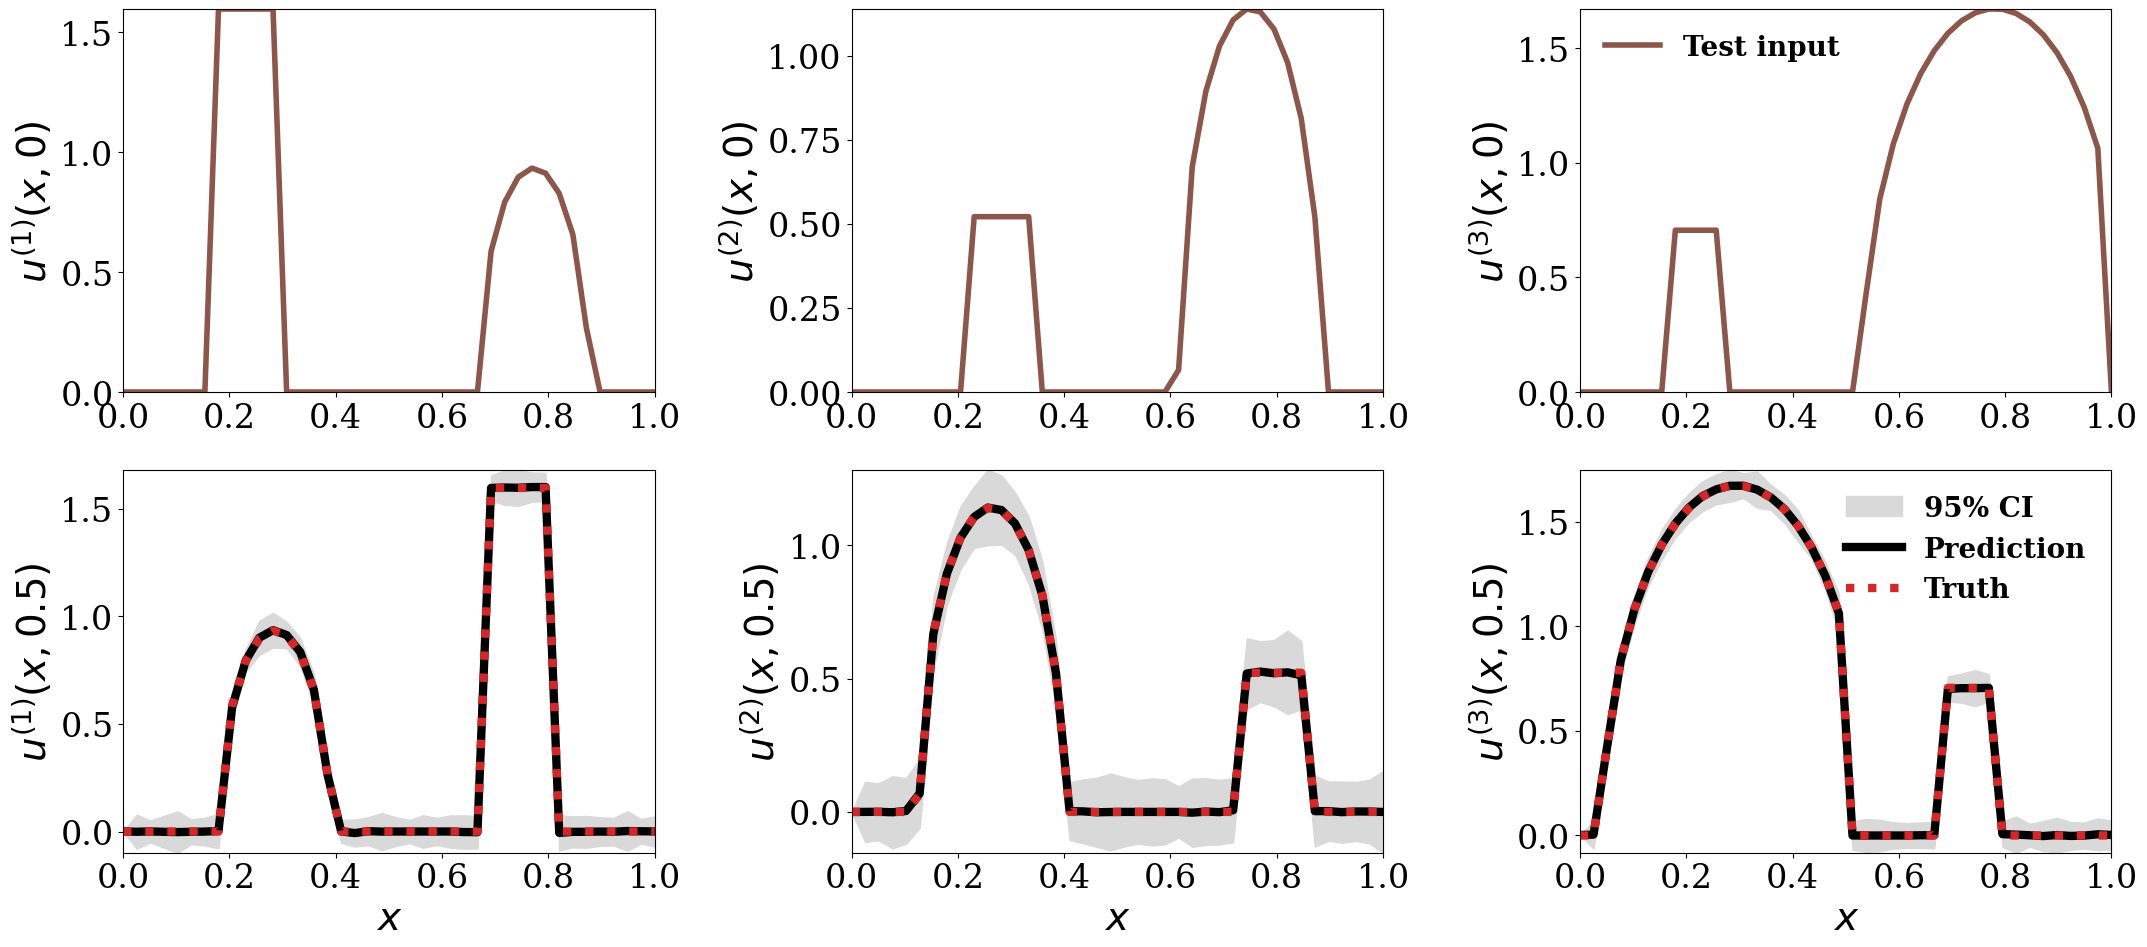

In [21]:

x_axis = np.linspace(0, 1, s).flatten()

num_xticks = 6  # Number of x-ticks
num_yticks = 6  # Number of y-ticks
x_ticks = np.linspace(x_axis.min(), x_axis.max(), num_xticks)
y_ticks = np.linspace(-1, 1, num_yticks)  

figure = plt.figure(figsize=(22, 10))  
plt.rcParams["font.family"] = "Serif"
plt.rcParams['font.size'] = 24

mean_pred = y_pred_sdd
std = std_pred * 1.96
num_subplots = 3

for subplot_idx in range(num_subplots):
    ax = figure.add_subplot(2, 3, subplot_idx + 1)  # First row (2 rows, 3 columns)
    
    i = subplot_idx + 4  # Set the value of i for each subplot
    
    ax.plot(x_axis, x_t.detach().cpu().numpy()[i, :], label="Test input", linewidth=4.0, color='tab:brown')
    # ax.set_xlabel("x", fontsize=28)
    ax.set_ylabel(f"$u^{{({subplot_idx + 1})}}(x,0)$", fontsize=28)
    ax.set_xticks(x_ticks)  # Set x-ticks
    plt.margins(0)
    
    if subplot_idx == 2:
        ax.legend(frameon=False, loc='upper left', prop={'weight': 'bold', 'size': 20})

# Second row: Plot predictions with confidence intervals
for subplot_idx in range(num_subplots):
    ax = figure.add_subplot(2, 3, subplot_idx + 4)  # Second row (2 rows, 3 columns)
    
    i = subplot_idx + 4  # Set the value of i for each subplot
    
    ax.fill_between(
        x_axis,
        (mean_pred[i, :] - std[i, :]).flatten(),
        (mean_pred[i, :] + std[i, :]).flatten(),
        color=(0.85,) * 3, label='95% CI'
    )
    ax.plot(x_axis, y_pred_sdd[i, :].flatten(), label="Prediction", linewidth=6.0, color='black')
    ax.plot(x_axis, y_t.detach().cpu().numpy()[i, :], ":", label="Truth", linewidth=6.0, color='tab:red')
    ax.set_xlabel("$x$", fontsize=28)
    ax.set_ylabel(f"$u^{{({subplot_idx + 1})}}(x,0.5)$", fontsize=28)
    ax.set_xticks(x_ticks)  # Set x-ticks
    # ax.set_yticks(y_ticks)  # Set y-ticks
    plt.margins(0)
    
    if subplot_idx == 2:
        ax.legend(frameon=False, loc='upper right', prop={'weight': 'bold', 'size': 20})

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig('/home/user/Documents/WaKeGP/experiments/C2_wa/results/sdd_WA_01_09_09.pdf',format='pdf',dpi=600,bbox_inches='tight')
plt.show()
